In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('/kaggle/input/adult-income-prediction-classification/data.csv')
df.head() 

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [3]:
df.shape

(32561, 15)

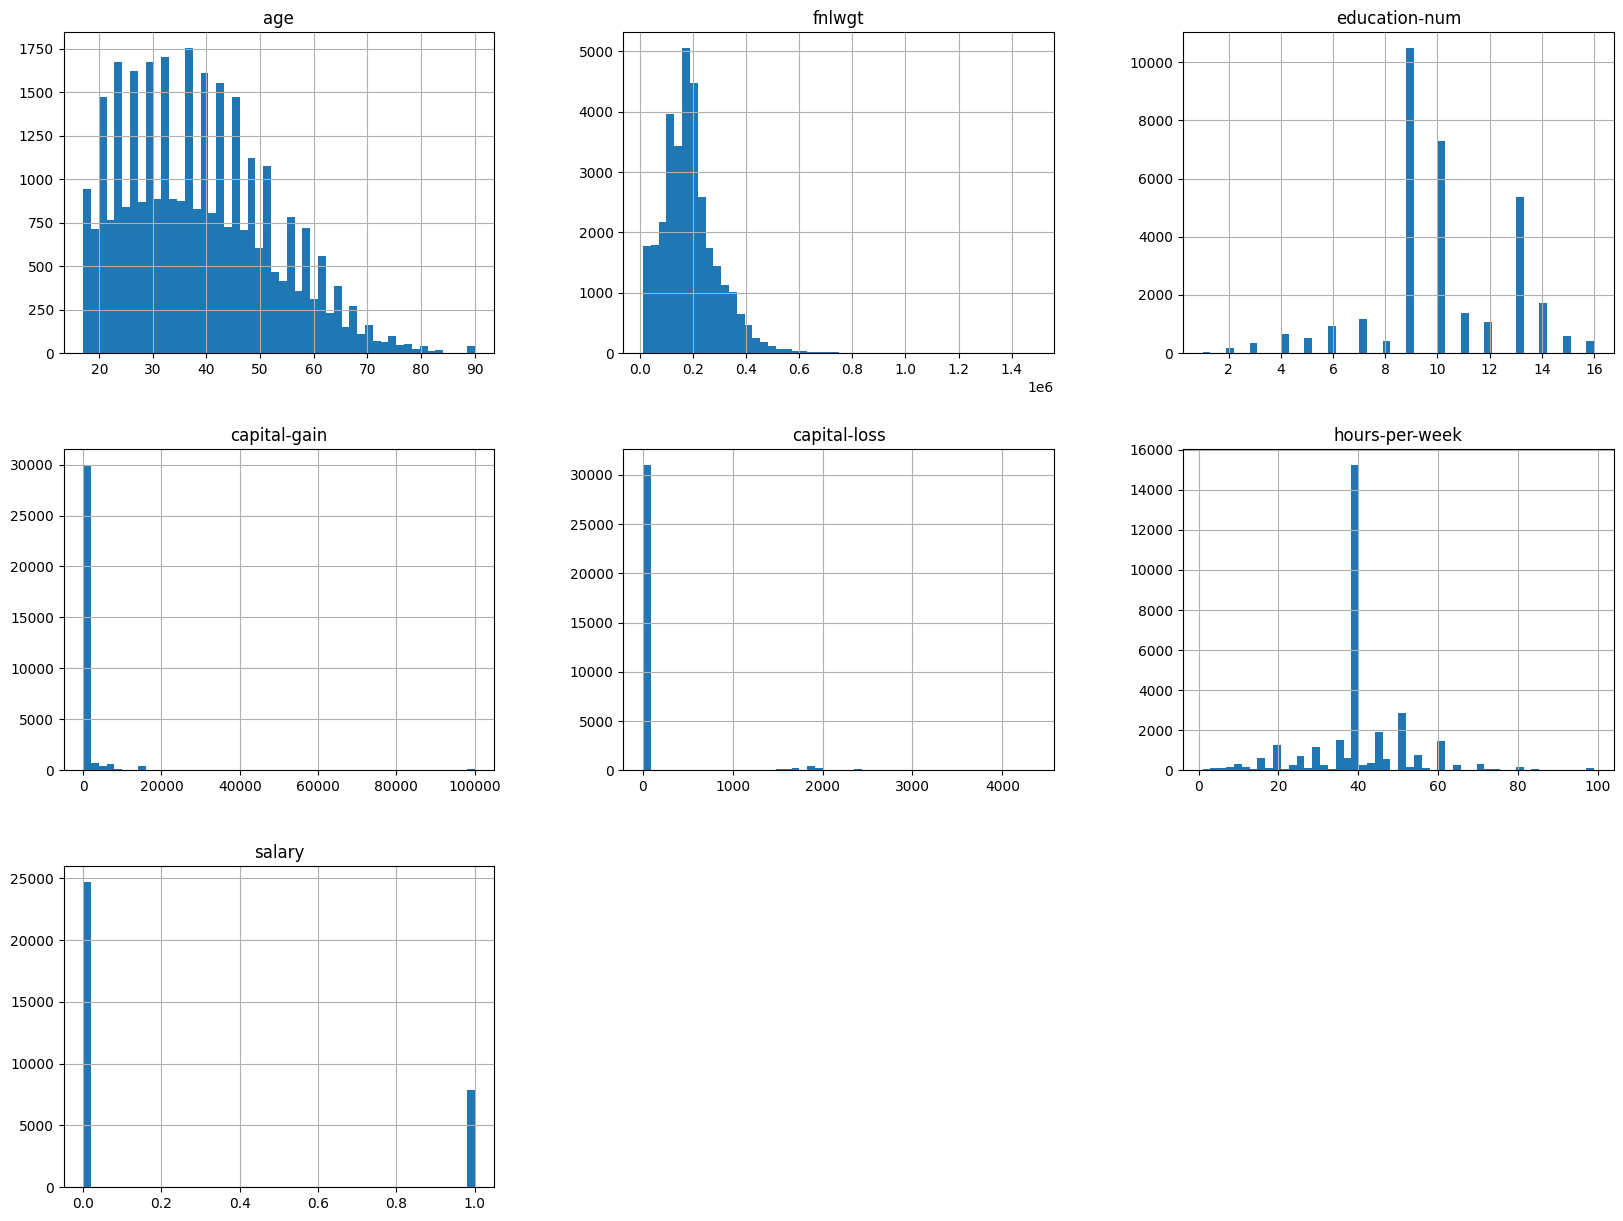

In [4]:
df.hist(bins=50, figsize=(20,15))
plt.show()

In [5]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df,explorative = True, title="Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
# Drop Duplicates
df = df.drop_duplicates()

### Removing higly correlated values as one feature can be predicted by other

In [7]:
# education and education-num have correlation so removing one of them.
df = df.drop(['education'], axis=1)
# sex and relationship have correlation so removing one of them
df = df.drop(['sex'], axis=1)

In [8]:
print(df.select_dtypes(['float', 'int']).columns)

print(df.select_dtypes(['object', 'bool']).columns)

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'salary'],
      dtype='object')
Index(['workclass', 'marital-status', 'occupation', 'relationship', 'race',
       'country'],
      dtype='object')


In [9]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
X = df.drop(['salary'], axis=1)
y = df['salary']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer

numeric_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
                    'hours-per-week']
categorical_features = ['workclass', 'marital-status', 'occupation', 'relationship', 
                        'race', 'country']

In [11]:
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder())
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report


In [13]:
models = {
    'RandomForest': {
        'model': RandomForestClassifier(),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [10, 20, None],
            'classifier__min_samples_split': [2, 5],
            'classifier__min_samples_leaf': [1, 2]
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(),
        'params': {
            'classifier__C': [0.1, 1, 10],
            'classifier__penalty': ['l1', 'l2'],
            'classifier__solver': ['liblinear', 'saga']
        }
    },
    'XGBoost': {
        'model': XGBClassifier(),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [3, 5, 7],
            'classifier__learning_rate': [0.01, 0.1],
            'classifier__subsample': [0.8, 1.0]
        }
    }
}


In [14]:
results = {}
accuracy_comparison = []

# Train and evaluate each model
for name, model_info in models.items():
    print(f"\n{'='*50}")
    print(f"Training and evaluating {name}...")
    print(f"{'='*50}")
    
    # Create pipeline for this model
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model_info['model'])
    ])
    
    # Perform GridSearch
    grid_search = GridSearchCV(
        pipeline,
        model_info['params'],
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    
    # Fit the grid search
    grid_search.fit(X_train, y_train)
    
    # Get best model
    best_model = grid_search.best_estimator_
    
    # Make predictions with best model
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    # Calculate accuracies
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    accuracy_diff = train_accuracy - test_accuracy
    
    # Store accuracy comparison
    accuracy_comparison.append({
        'Model': name,
        'Training Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'Difference': accuracy_diff,
        'Best Parameters': grid_search.best_params_
    })
    
    # Print detailed results
    print(f"\nResults for {name}:")
    print(f"Training Accuracy: {train_accuracy:.3f}")
    print(f"Test Accuracy: {test_accuracy:.3f}")
    print(f"Difference (Train - Test): {accuracy_diff:.3f}")
    print("\nBest Parameters:")
    print(grid_search.best_params_)
    
    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_test_pred))

# Create comparison DataFrame
comparison_df = pd.DataFrame(accuracy_comparison)
comparison_df = comparison_df.set_index('Model')
comparison_df = comparison_df.sort_values('Test Accuracy', ascending=False)

print("\nModel Accuracy Comparison:")
print(comparison_df[['Training Accuracy', 'Test Accuracy', 'Difference']].round(3))

# Print model analysis
print("\nModel Analysis:")
for index, row in comparison_df.iterrows():
    print(f"\n{index}:")
    print(f"  Training Accuracy: {row['Training Accuracy']:.3f}")
    print(f"  Test Accuracy: {row['Test Accuracy']:.3f}")
    print(f"  Difference: {row['Difference']:.3f}")
    
    if row['Difference'] > 0.1:
        print("  Status: Potential overfitting")
    elif row['Difference'] < -0.1:
        print("  Status: Unusual pattern - test accuracy higher than training")
    else:
        print("  Status: Good fit")


Training and evaluating RandomForest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  warnings.warn(



Results for RandomForest:
Training Accuracy: 0.871
Test Accuracy: 0.860
Difference (Train - Test): 0.011

Best Parameters:
{'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      7405
           1       0.81      0.55      0.65      2357

    accuracy                           0.86      9762
   macro avg       0.84      0.75      0.78      9762
weighted avg       0.86      0.86      0.85      9762


Training and evaluating LogisticRegression...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(



Results for LogisticRegression:
Training Accuracy: 0.822
Test Accuracy: 0.823
Difference (Train - Test): -0.001

Best Parameters:
{'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      7405
           1       0.71      0.45      0.55      2357

    accuracy                           0.82      9762
   macro avg       0.78      0.70      0.72      9762
weighted avg       0.81      0.82      0.81      9762


Training and evaluating XGBoost...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  warnings.warn(



Results for XGBoost:
Training Accuracy: 0.841
Test Accuracy: 0.848
Difference (Train - Test): -0.007

Best Parameters:
{'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.85      0.97      0.91      7405
           1       0.82      0.47      0.60      2357

    accuracy                           0.85      9762
   macro avg       0.84      0.72      0.75      9762
weighted avg       0.85      0.85      0.83      9762


Model Accuracy Comparison:
                    Training Accuracy  Test Accuracy  Difference
Model                                                           
RandomForest                    0.871          0.860       0.011
XGBoost                         0.841          0.848      -0.007
LogisticRegression              0.822          0.823      -0.001

Model Analysis:

RandomForest:
  Trai